In [43]:
import pandas as pd
from datasets import Dataset
import torch
import evaluate
import numpy as np


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline
from transformers import AutoTokenizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv', usecols=['text','target'])
df.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


In [3]:
print(f"Shape Of Data {df.shape}")
df.info()

Shape Of Data (7613, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [4]:
df.describe()

,target
count,7613.00000
mean,0.42966
std,0.49506
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


In [5]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [6]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,text,target
0,MH370: Reunion debris is from missing Malaysia...,1
1,@JetixRestored Here's Part 2 Of Teamo Supremo ...,0
2,I hear the mumbling i hear the cackling i got ...,0
3,@DelDryden If I press on the twitch will my he...,0
4,#flood #disaster Heavy rain causes flash flood...,1
5,'Education is the most powerful weapon which y...,0
6,Perfect night for a soak! Lava here I come?? h...,0
7,@Dani_Riot keep an eye out we'll be looking fo...,0
8,ÛÏ@TheHighFessions: 'My friend came to school...,0
9,RAIN RAIN GO AWAY... A soaker is on the way \n...,0


In [7]:
df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: >

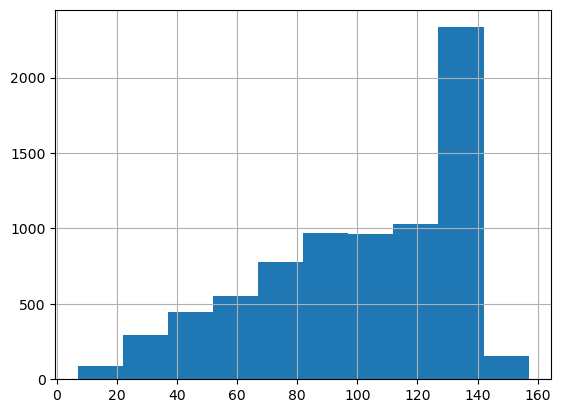

In [8]:
df['text'].str.len().hist()

In [38]:
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'target'],
        num_rows: 1523
    })
})

In [10]:
id2label  = {0:'general',1:'disaster'}
label2id = {'general':0, 'disaster':1}

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_ckpt = 'huawei-noah/TinyBERT_General_4L_312D'
tokenaizer = AutoTokenizer.from_pretrained(model_ckpt)

In [12]:
tokenaizer

BertTokenizerFast(name_or_path='huawei-noah/TinyBERT_General_4L_312D', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [25]:
tokenaizer(dataset['train'][0]['text'])

def tokenize(batch):
    temp = tokenaizer(batch['text'], truncation=True, padding=True, max_length=300)
    temp['labels'] = batch['target']
    return temp
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [26]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['text', 'target', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1523
    })
})

In [40]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    perdiction, label = eval_pred
    perdiction = np.argmax(perdiction, axis=1)
    return accuracy.compute(predictions=perdiction, references=label)

In [41]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(label2id), id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [30]:
args = TrainingArguments(
    output_dir='train_dir',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    overwrite_output_dir=True,
    learning_rate=1e-5,
    eval_strategy='epoch',
    report_to='none',  # این خط را اضافه کنید
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenaizer
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.490455,0.780039
2,0.539200,0.479613,0.789888


TrainOutput(global_step=762, training_loss=0.508350101981576, metrics={'train_runtime': 443.6724, 'train_samples_per_second': 27.453, 'train_steps_per_second': 1.717, 'total_flos': 28653347298240.0, 'train_loss': 0.508350101981576, 'epoch': 2.0})

In [32]:
trainer.evaluate()

{'eval_loss': 0.47961345314979553,
 'eval_accuracy': 0.7898883782009193,
 'eval_runtime': 10.7401,
 'eval_samples_per_second': 141.804,
 'eval_steps_per_second': 8.938,
 'epoch': 2.0}

In [33]:
trainer.save_model("tinybert_disaster_tweet")

In [34]:
data = ['this movie was horrible, the plot was really boring. acting was okay',
        'the fild is really sucked. there is not plot and acting was bad',
        'what a beautiful movie. great plot. acting was good. will see it again']

In [42]:
classifier = pipeline('text-classification', model='tinybert_disaster_tweet', tokenizer=tokenaizer, device=0)
classifier(data)

Device set to use cpu


[{'label': 'general', 'score': 0.8426923751831055},
 {'label': 'general', 'score': 0.8444386720657349},
 {'label': 'general', 'score': 0.8479562997817993}]